# Rose Tovar
## Hypothesis Testing

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRuRgiZaLcdq_937t8Psne-9AWR5VwSQYnt6PgMdDPFaVdOeP4xxA9h7_2mAYEsh8DOYzoh0XAqeQa0/pub?gid=2071196080&single=true&output=csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Data Cleaning

In [3]:
#fixing inconsistencies in Item Fat Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', "Regular")
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')

df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

# Hypothesis Test 1
- Does Outlet Type Affect how the outlet sales

- Null Hypothesis : Outlet Type does not affect item outlet sales
- Alternative Hypothesis : Outlet type affects the item outlet sales

In [4]:
df1 = df[['Outlet_Type', 'Item_Outlet_Sales']]
df1.head()

,Outlet_Type,Item_Outlet_Sales
0,Supermarket Type1,3735.1380
1,Supermarket Type2,443.4228
2,Supermarket Type1,2097.2700
3,Grocery Store,732.3800
4,Supermarket Type1,994.7052


In [5]:
df1['Outlet_Type'].value_counts(dropna=False)

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

## Creating Groups for Hypothesis Testing

In [6]:
groups = {}
for i in df1['Outlet_Type'].unique():
    data = df1.loc[df1['Outlet_Type']==i, 'Item_Outlet_Sales'].copy()
    
    groups[i] = data
    
groups.keys()

dict_keys(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store', 'Supermarket Type3'])

In [7]:
len(groups['Grocery Store'])

1083

## Hypothesis Testing for Multiple Groups

- We are dealing with numeric data we must take the following in account: 

- We must use One way Avona
- No Outliers
- Normality
- Equal Variance

### Removing Outliers

In [8]:
for i, data in groups.items():
    zscores = stats.zscore(data)
    outliers = abs(zscores) > 3
    print(f"You have {np.sum(outliers)} outliers in {i}")
    groups[i] = data[np.abs(stats.zscore(data)) < 3]

You have 52 outliers in Supermarket Type1
You have 11 outliers in Supermarket Type2
You have 15 outliers in Grocery Store
You have 6 outliers in Supermarket Type3


In [9]:
len(groups['Grocery Store'])

1068

### Checking For Normality

In [10]:
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    
    norm_results[i] = {
        'n': len(data),
        "p": p,
        'test_stat': stat
    }
    
norm_df = pd.DataFrame(norm_results).T
norm_df

,n,p,test_stat
Supermarket Type1,5525.0,4.082593e-107,489.939745
Supermarket Type2,917.0,5.681445e-24,107.049673
Grocery Store,1068.0,1.928640e-38,173.682837
Supermarket Type3,929.0,7.217378e-13,55.914229


In [11]:
### checking sig with pandas 
norm_df['sig'] = norm_df['p'] < .05 
norm_df

,n,p,test_stat,sig
Supermarket Type1,5525.0,4.082593e-107,489.939745,True
Supermarket Type2,917.0,5.681445e-24,107.049673,True
Grocery Store,1068.0,1.928640e-38,173.682837,True
Supermarket Type3,929.0,7.217378e-13,55.914229,True


- Because the p value is less than .05 for each of these fields we must reject the null hypothesis that they are normal. But because of the amount of points we have in each field we can move forward with hypothesis testing

### Checking for Equal Variance

In [12]:
results = stats.levene(*groups.values())
if results.pvalue < 0.05:
    print("Reject the Null Hypothesis")
else:
    print('The Null Hypothesis is correct')

Reject the Null Hypothesis


- Because we have  p value less than .05 we must reject the null hypothesis that they have equal variance. This means we must move forward with using the Kruskal Wallis Test

### Final Hypothosis Test

In [13]:
results = stats.kruskal(*groups.values())
if results.pvalue < 0.05:
    print("Reject the Null Hypothesis")
else:
    print('The Null Hypothesis is correct')

Reject the Null Hypothesis


- Our Kruskal Wallis Test told us to reject the null hypothesis that Outlet types make  more Item Outlet Sales

In [14]:
df1 = pd.DataFrame(columns=['Outlet_Type', 'Item_Outlet_Sales'])
counter = 0
for i in groups:
    for num in groups[i]:
        df1.loc[counter] = [i, num]
        counter +=1
df1.reset_index()
df1.head()

,Outlet_Type,Item_Outlet_Sales
0,Supermarket Type1,3735.1380
1,Supermarket Type1,2097.2700
2,Supermarket Type1,994.7052
3,Supermarket Type1,343.5528
4,Supermarket Type1,1076.5986


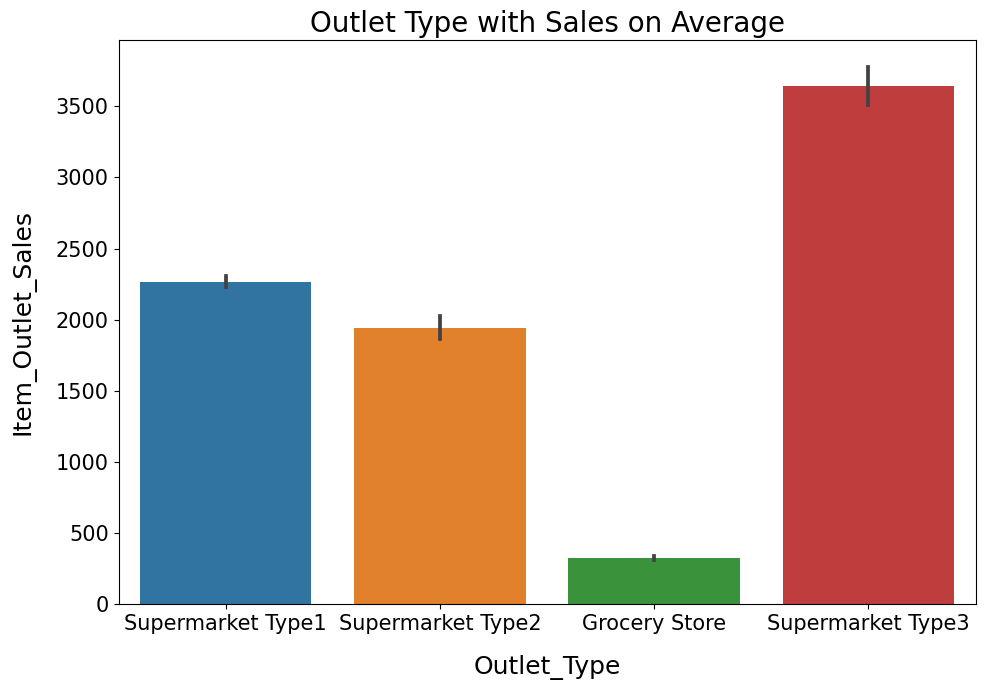

In [31]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df1, x='Outlet_Type', y='Item_Outlet_Sales',ax=ax)
ax.set_xlabel("Outlet_Type", fontsize=18,labelpad=15)
ax.set_ylabel("Item_Outlet_Sales", fontsize=18,labelpad=15)
ax.set_title('Outlet Type with Sales on Average', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.tight_layout()

# Hypothesis Test 2

 - Do Item Types have different Item Outlet Sales
 
 - Null Hypothesis: Item Types have around the same item outlet sales
 - Alternative Hypothesis: Certain item Types have better Itme outlet Sales

## Pulling Data

In [16]:
df2 = df[['Item_Type', 'Item_Outlet_Sales']]
df2.head()

,Item_Type,Item_Outlet_Sales
0,Dairy,3735.1380
1,Soft Drinks,443.4228
2,Meat,2097.2700
3,Fruits and Vegetables,732.3800
4,Household,994.7052


In [17]:
df2['Item_Type'].value_counts(dropna=False)

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

## Creating Groups

In [18]:
groups = {}
for i in df2['Item_Type'].unique():
    data = df2.loc[df2['Item_Type'] == i, 'Item_Outlet_Sales'].copy()
    
    groups[i] = data
    
groups.keys()

dict_keys(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables', 'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods', 'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned', 'Breads', 'Starchy Foods', 'Others', 'Seafood'])

In [19]:
len(groups['Dairy'])

682

## Hypothesis Testing For Multiple Groups

- Because we are dealing with numeric data with multiple groups we must take in to account the following

- We must use One way Avona

- No Outliers
- Normality
- Equal Variance

### Removing Outliers

In [20]:
# this loops through and remove outliers
for i, data in groups.items():
    zscores = stats.zscore(data)
    outliers = abs(zscores) > 3
    print(f"You have {np.sum(outliers)} outliers in {i}")
    groups[i] = data[np.abs(stats.zscore(data)) < 3]

You have 11 outliers in Dairy
You have 8 outliers in Soft Drinks
You have 4 outliers in Meat
You have 10 outliers in Fruits and Vegetables
You have 7 outliers in Household
You have 7 outliers in Baking Goods
You have 14 outliers in Snack Foods
You have 8 outliers in Frozen Foods
You have 2 outliers in Breakfast
You have 8 outliers in Health and Hygiene
You have 3 outliers in Hard Drinks
You have 5 outliers in Canned
You have 2 outliers in Breads
You have 1 outliers in Starchy Foods
You have 0 outliers in Others
You have 0 outliers in Seafood


In [21]:
len(groups['Dairy'])

671

### Check For Normality

In [22]:
### Run normal for each cell
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    
    norm_results[i] = {
        'n': len(data),
        "p": p,
        "test_stat": stat
    }

norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test_stat
Dairy,671.0,2.841185e-19,85.409791
Soft Drinks,437.0,1.391906e-15,68.416204
Meat,421.0,1.901418e-10,44.766503
Fruits and Vegetables,1222.0,2.743323e-28,126.926425
Household,903.0,4.548575e-16,70.653095
Baking Goods,641.0,9.986473e-17,73.685430
Snack Foods,1186.0,5.481006e-23,102.516337
Frozen Foods,848.0,3.540229e-21,94.180191
Breakfast,108.0,1.642043e-05,22.033968
Health and Hygiene,512.0,1.988884e-12,53.886895


In [23]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test_stat,sig
Dairy,671.0,2.841185e-19,85.409791,True
Soft Drinks,437.0,1.391906e-15,68.416204,True
Meat,421.0,1.901418e-10,44.766503,True
Fruits and Vegetables,1222.0,2.743323e-28,126.926425,True
Household,903.0,4.548575e-16,70.653095,True
Baking Goods,641.0,9.986473e-17,73.685430,True
Snack Foods,1186.0,5.481006e-23,102.516337,True
Frozen Foods,848.0,3.540229e-21,94.180191,True
Breakfast,108.0,1.642043e-05,22.033968,True
Health and Hygiene,512.0,1.988884e-12,53.886895,True


- because the p value is less than .05 for each of these we must reject the null hypothesis that they are normal. But because of the amount of data points in each group we can move forward with the hypothesis testing

### Checking for Equal Variance

In [24]:
# Testing for equal variance
results = stats.levene(*groups.values())
if results.pvalue < 0.05:
    print("Reject the Null Hypothesis")
else:
    print('The Null Hypothesis is correct')

Reject the Null Hypothesis


- When we use the levene test in order to test for equal variance we can see that we must reject the null hypothesis that they have equal variance. This means we must move forward with using the Kruskal Wallis test

### Final Hypothesis Test

In [25]:
results = stats.kruskal(*groups.values())

if results.pvalue < 0.05:
    print("Reject the Null Hypothesis")
else:
    print('The Null Hypothesis is correct')

Reject the Null Hypothesis


- Our Kruskal Wallis Test tells us to reject the null hypothesis that Item Type does not affect Item Outlet Sales. This test tells us that there is a signficant difference in Item Outlet Sales based on item type

In [27]:
df2 = pd.DataFrame(columns=['Item_Type', 'Item_Outlet_Sales'])
counter = 0
for i in groups:
    for num in groups[i]:
        df2.loc[counter] = [i, num]
        counter +=1
df2.reset_index()
df2.head()

,Item_Type,Item_Outlet_Sales
0,Dairy,3735.1380
1,Dairy,2187.1530
2,Dairy,2748.4224
3,Dairy,178.4344
4,Dairy,163.7868


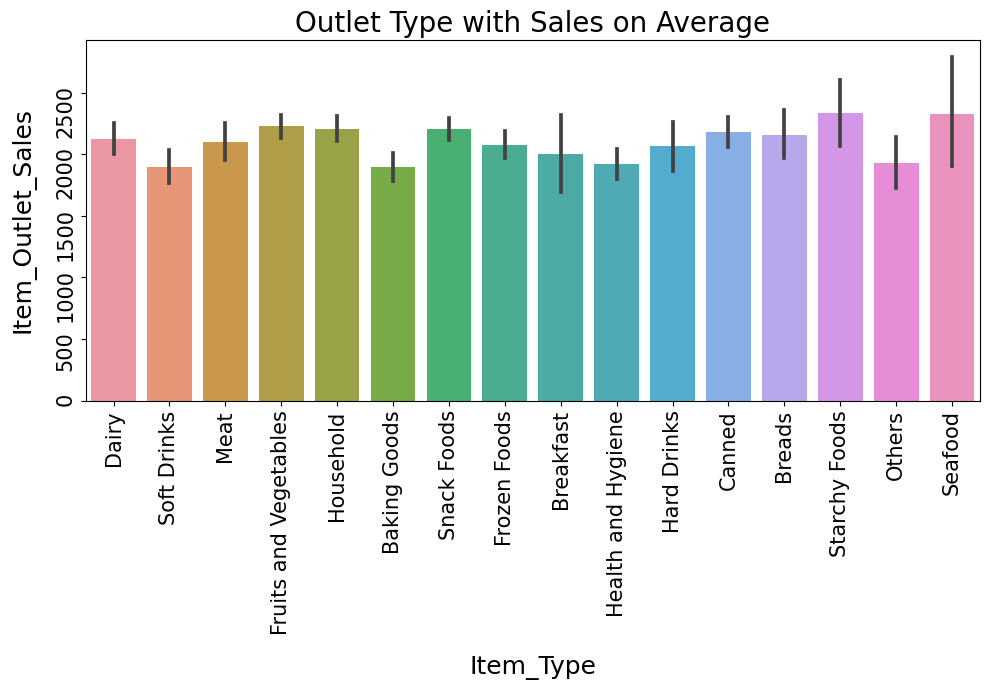

In [32]:
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df2, x='Item_Type', y='Item_Outlet_Sales',ax=ax)
ax.set_xlabel("Item_Type", fontsize=18,labelpad=15)
ax.set_ylabel("Item_Outlet_Sales", fontsize=18,labelpad=15)
ax.set_title('Outlet Type with Sales on Average', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15, rotation=90)
plt.tight_layout()

> This plot shows us that different Items have different Item Outlet Sales. This confirms out hypothesis testing that there is a difference in Item Outlet Sales based on the Item Type